### Import Libraries

In [15]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)

import time
import warnings
warnings.filterwarnings("ignore")
import gc
import os
import cv2

from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain

from itertools import chain
from skimage.color import rgb2gray
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

#sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils.vis_utils import plot_model

from mpl_toolkits.axes_grid1 import ImageGrid

import sys
sys.path.append('../')
from Model.model import segment
from utilities.data_generator import data_gen
from utilities.segment_metrics import Quality_metrics

### Reproducibility

In [3]:
# Set random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

### Training  images

In [4]:
train_files = []
mask_files = glob('../data/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

In [5]:
x = mask_files[20]
np.max(cv2.imread(x))

0

### Data Distribution by creating table

In [6]:
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'
    
df = pd.DataFrame({"image_path": train_files,
                   "mask_path": mask_files,
                  "diagnosis":[diagnosis(x) for x in mask_files]})    

In [7]:
df.head()

,image_path,mask_path,diagnosis
0,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,0
1,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,1
2,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,1
3,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,1
4,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,1


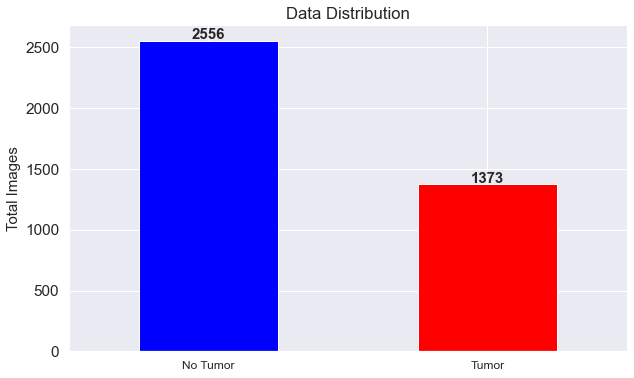

In [8]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

### Visulaize MRI Images with masks

In [9]:
df_positive = df[df['diagnosis']=='1'].sample(5).values
df_negative = df[df['diagnosis']=='0'].sample(5).values

In [10]:
def show_data(df, positive=True):
    images = []
    masks = []
    for data in df:
        img = cv2.imread(data[0])
        mask = cv2.imread(data[1])
        images.append(img)
        masks.append(mask)
    images = np.hstack(np.array(images))
    masks = np.hstack(np.array(masks))
    
    fig = plt.figure(figsize=(25,25))
    if positive:
        grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)
    else:
        grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.5)
    grid[0].imshow(images)
    grid[0].set_title('Images', fontsize=15)
    grid[0].axis('off')
    grid[1].imshow(masks)
    grid[1].set_title('Masks', fontsize=15)
    grid[1].axis('off')
    if positive:
        grid[2].imshow(images)
        grid[2].imshow(masks, alpha=0.4)
        grid[2].set_title('Brain MRI with mask', fontsize=15)
        grid[2].axis('off')

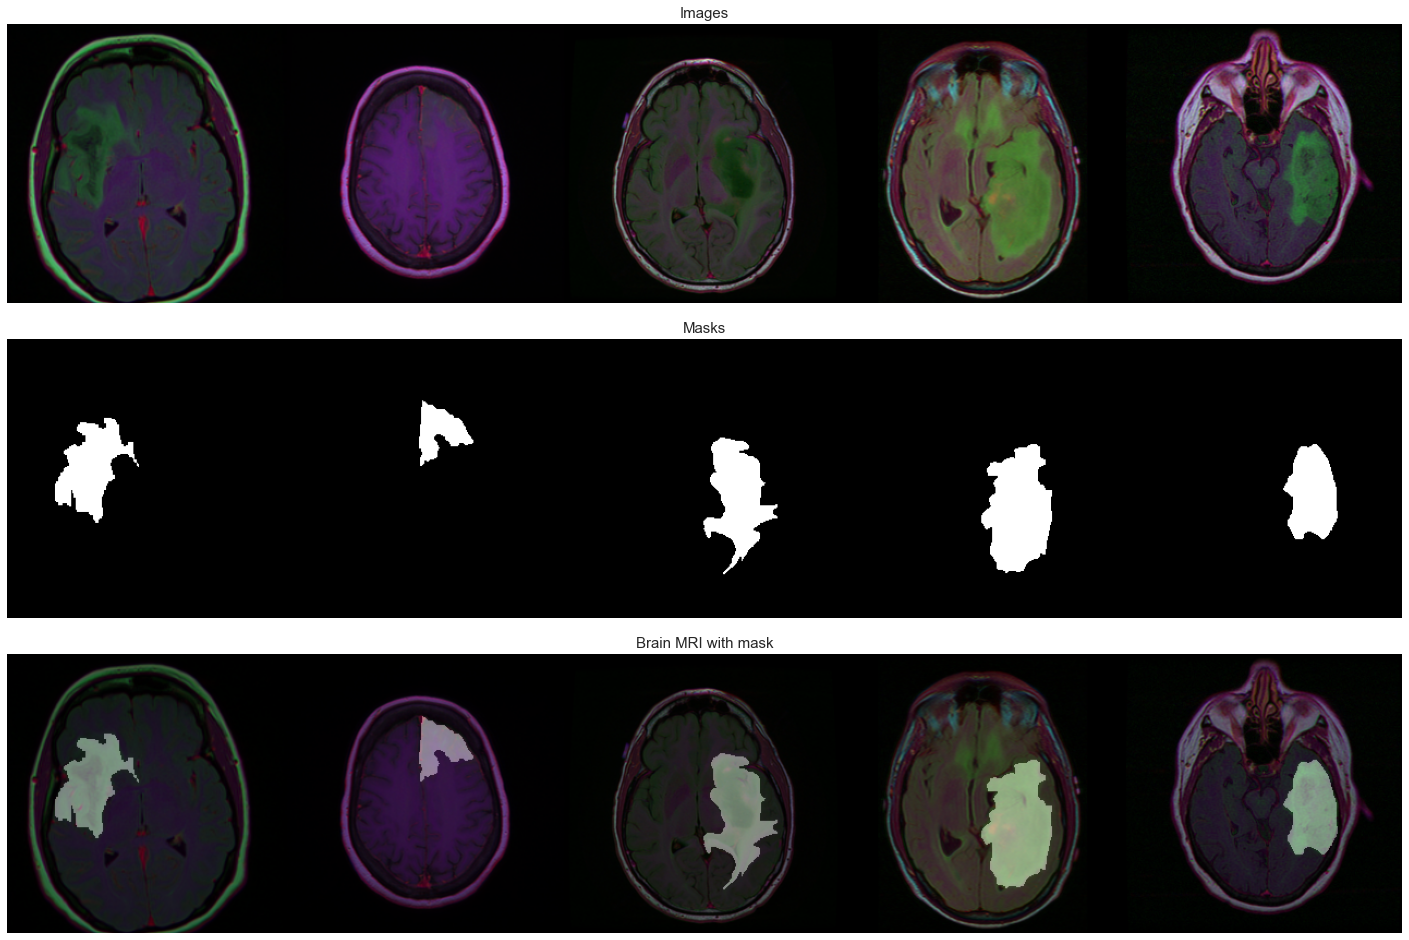

In [11]:
show_data(df_positive)

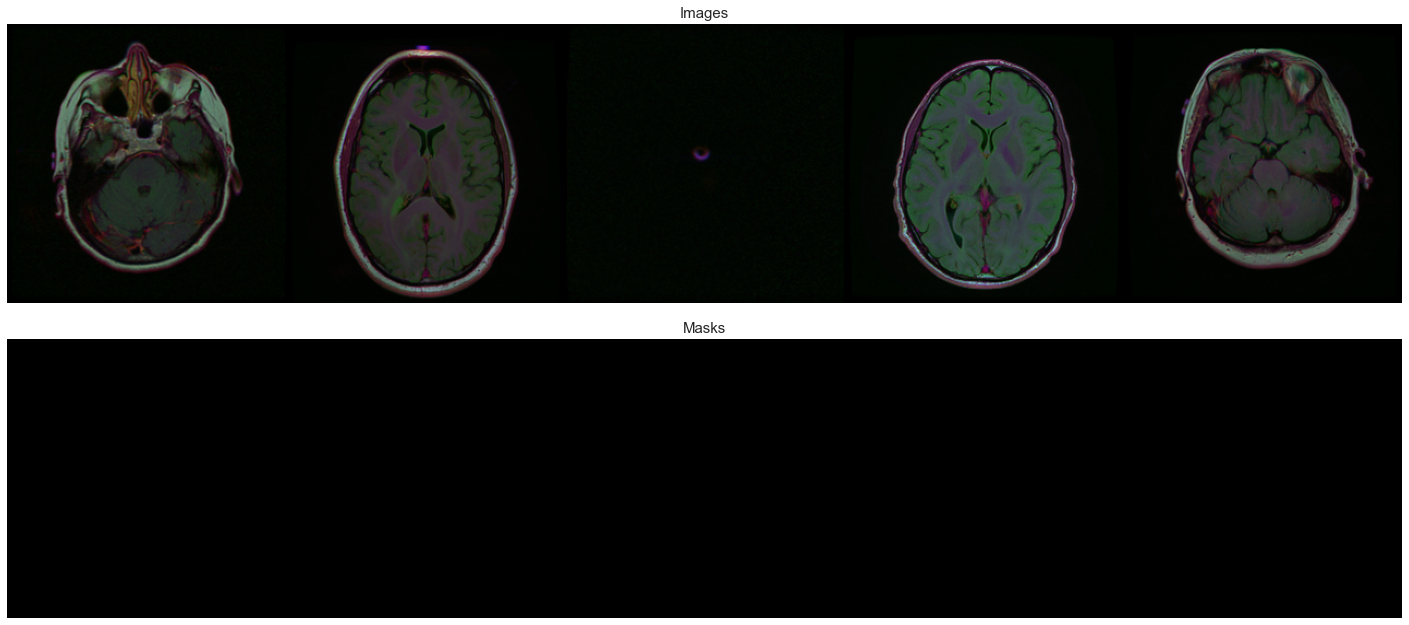

In [12]:
show_data(df_negative, positive=False)

### Split data into Train, Validation and Test Set

In [13]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2838, 3)
(501, 3)
(590, 3)


### Build the Model

In [16]:
# !pygmentize ../Model/model.py

n_filters= 64
input_size=(256, 256, 3)
n_classes=1

obj = segment(n_filters, input_size, n_classes)

In [17]:
model = obj.build_unet()

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

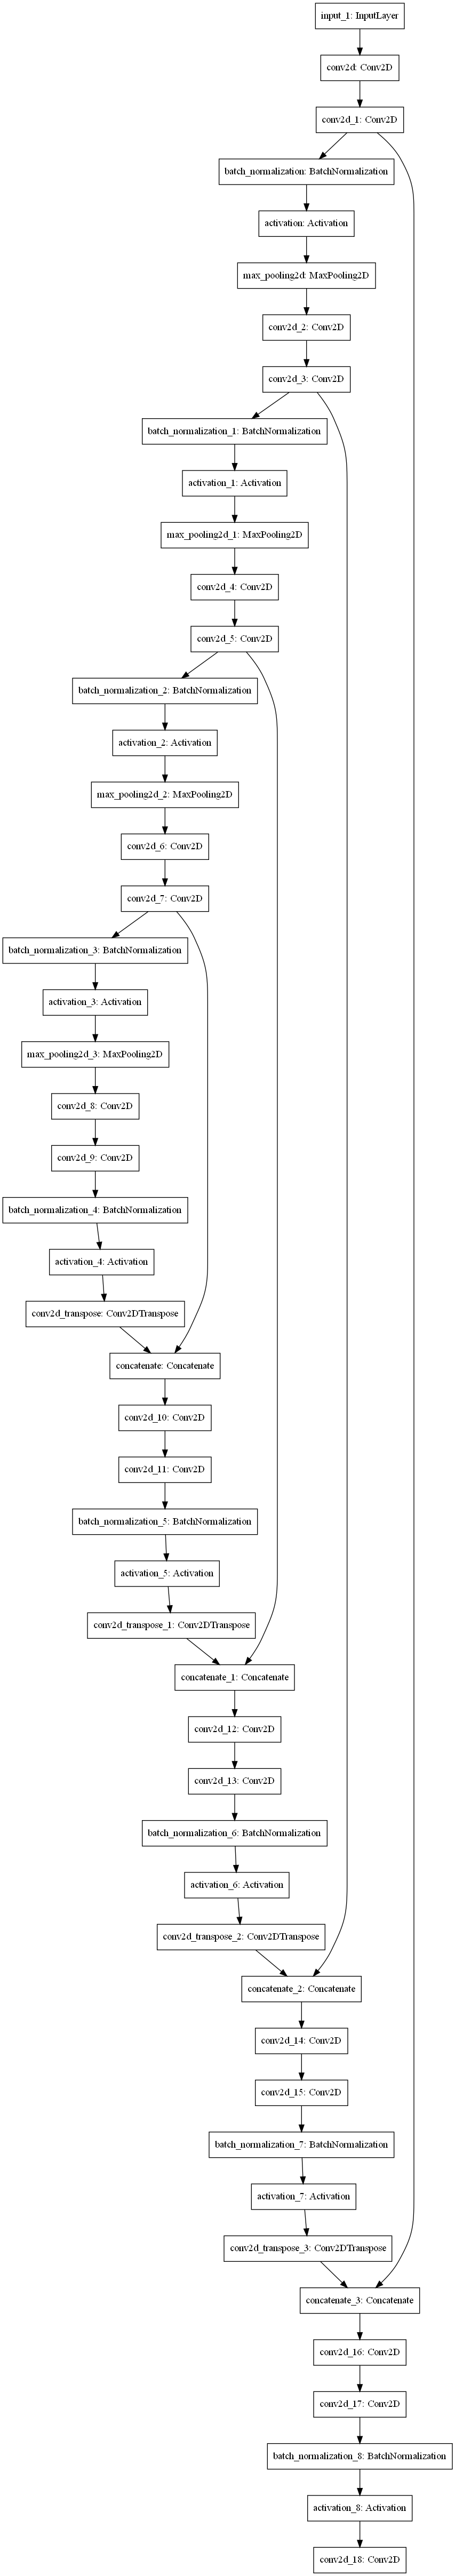

In [19]:
# Plot model architecture
plot_model(model)

### Training

In [20]:
# Set parameters
EPOCHS = 12
BATCH_SIZE = 32
learning_rate = 1e-3

# Set parameters
IMAGE_SIZE = (256, 256)

In [21]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

In [22]:
t_obj = data_gen()
metric_obj = Quality_metrics(1)

In [23]:
train_gen = t_obj.train_generator(df_train, 
                        BATCH_SIZE,
                        train_generator_args,
                        target_size=IMAGE_SIZE
                        )

val_gen =  t_obj.train_generator(df_val, 
                                BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE
                                )

In [ ]:
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=metric_obj.bce_dice_loss, metrics=[metric_obj.iou, metric_obj.dice_coef])

In [ ]:
callbacks = [ModelCheckpoint('unet_brainMRI_seg.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)]

In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

In [36]:
callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    #callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

### Visualizing the model performance

In [37]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(model.history.history['loss'], 'b-', label='train_loss')
plt.plot(model.history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(model.history.history['iou'], 'b-', label='train_iou')
plt.plot(model.history.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(model.history.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(model.history.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

 ### Evaluate the model

In [39]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

In [41]:
for i in range(20):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()